# Benchmark: PXD024043 - Proteins

In this notebook, we will evalulate imputation performance by introducing additional missing values to the dataset and then imputing them using the trained model.

Let's start with the imports.

In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm
import scp.simulations as sm
import scp.metrics as metrics

import scvi

np.random.seed(42)
scvi.settings.seed = 42

Global seed set to 42


In [17]:
adata = sc.read("../../../data/processed/brunner2022.h5ad")

Let's generate the missing data.

In [18]:
m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.08, mnar_proportion=1, x=adata.layers["raw"], seed=42, sd_scale=5)

In [19]:
print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

MNAR: 0.041, MCAR: 0.000


In [20]:
train_mask = ~(m_mcar | m_mnar)

sm.add_train_test_set(adata, train_mask, layer="raw")

## PROTVI

### Training

Let's now train the model.

In [29]:
adata.X = adata.layers["train"].copy()
adata.X[np.isnan(adata.X)] = 0

In [30]:
PROTVI.setup_anndata(adata) #, batch_key="coarse_condition")

model = PROTVI(adata, log_variational=False, n_hidden=16, decoder_type="hybrid", max_loss_dropout=0.3)
#model.view_anndata_setup()

Let's train the model.

In [31]:
model.train(max_epochs=4000, plan_kwargs={"mechanism_weight": 0.1, "lr": 5e-3}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 6, "max_kl_weight": 6})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 4000/4000: 100%|██████████| 4000/4000 [12:08<00:00,  6.65it/s, v_num=1, train_loss_step=208, train_loss_epoch=120]      

`Trainer.fit` stopped: `max_epochs=4000` reached.


Epoch 4000/4000: 100%|██████████| 4000/4000 [12:08<00:00,  5.49it/s, v_num=1, train_loss_step=208, train_loss_epoch=120]


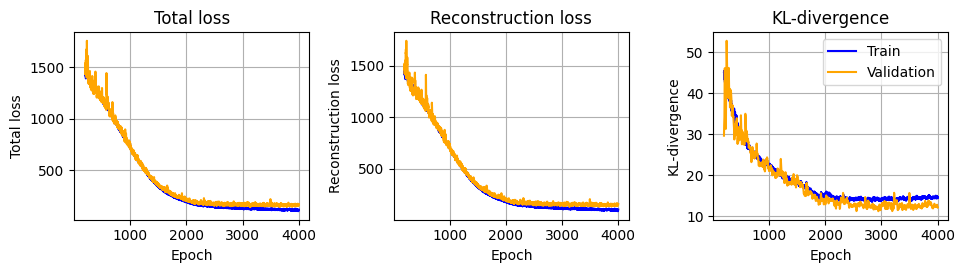

In [32]:
pl.plot_loss(model.history, epoch_start=200)

### Evaluation on training set

In [41]:
x_est, p_est, x_var = model.impute(n_samples=100)

In [42]:
x_test = adata.layers["test"]

x_guess = x_est.copy()
x_guess[np.isnan(x_test)] = np.nan

x_true = x_test.copy()

In [43]:
mse_test = metrics.mse(x_guess[~np.isnan(x_test)], x_true[~np.isnan(x_test)])
print(f"Test MSE: {mse_test:.4f}")

Test MSE: 0.1280


Text(0.5, 1.0, 'Imputation accuracy (MSE: 0.1280)')

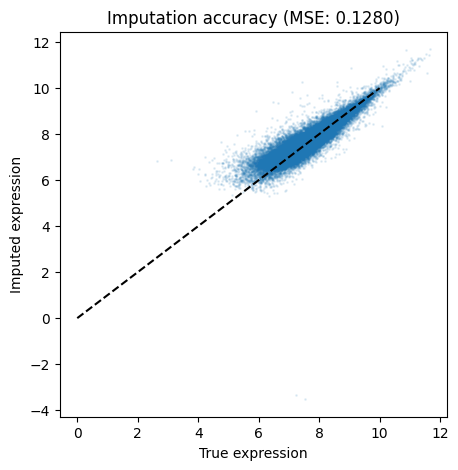

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot([0, 10], [0, 10], ls="--", c="black")
ax.scatter(x_true, x_guess, s=1, alpha=0.1)
ax.set_xlabel("True expression")
ax.set_ylabel("Imputed expression")
ax.set_title(f"Imputation accuracy (MSE: {mse_test:.4f})")